In [16]:
from support.df_init import init

train = init()
test = init('pp_test.csv')

In [17]:
train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
       'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
       'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
       'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
       'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
       'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe', 'countryOfOrigin', 'countryOfOrigin_freq_enc',
       'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryO

# has_lowEngagement

In [18]:
train['has_lowEngagement'] = (train['numVotes'] < 100).astype(int)
test['has_lowEngagement'] = (test['numVotes'] < 100).astype(int)

In [19]:
print("Train has_lowEngagement counts:")
print(train['has_lowEngagement'].value_counts())

print("\nTest has_lowEngagement counts:")
print(test['has_lowEngagement'].value_counts())

Train has_lowEngagement counts:
has_lowEngagement
1    11105
0     5067
Name: count, dtype: int64

Test has_lowEngagement counts:
has_lowEngagement
1    3686
0    1698
Name: count, dtype: int64


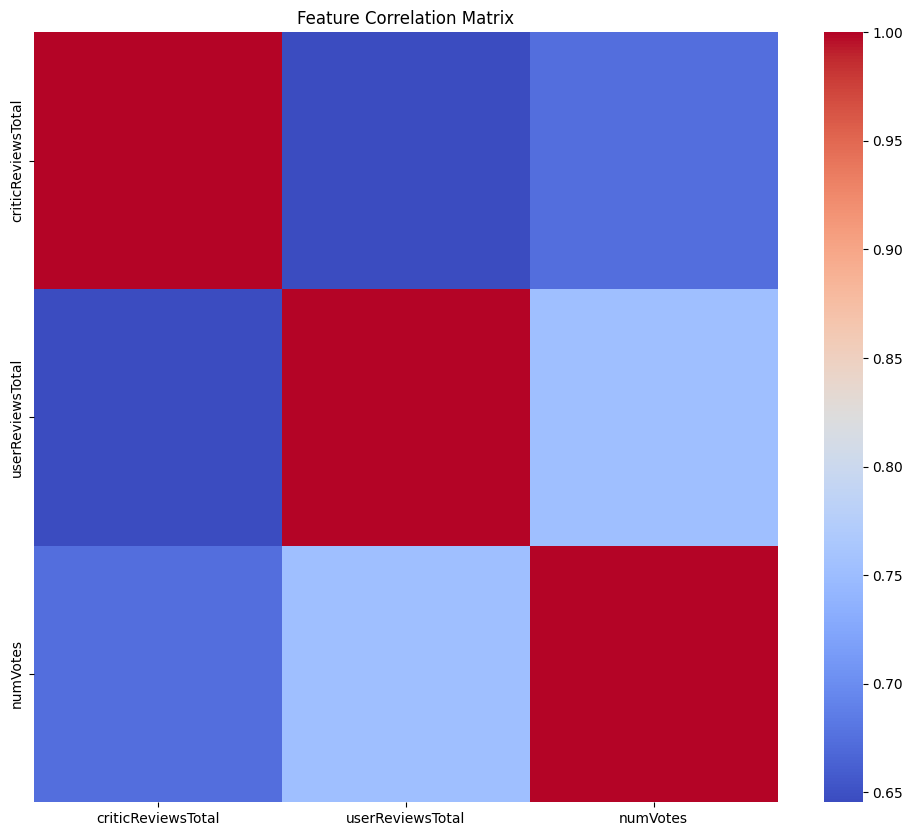

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = train[['criticReviewsTotal', 'userReviewsTotal', 'numVotes']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

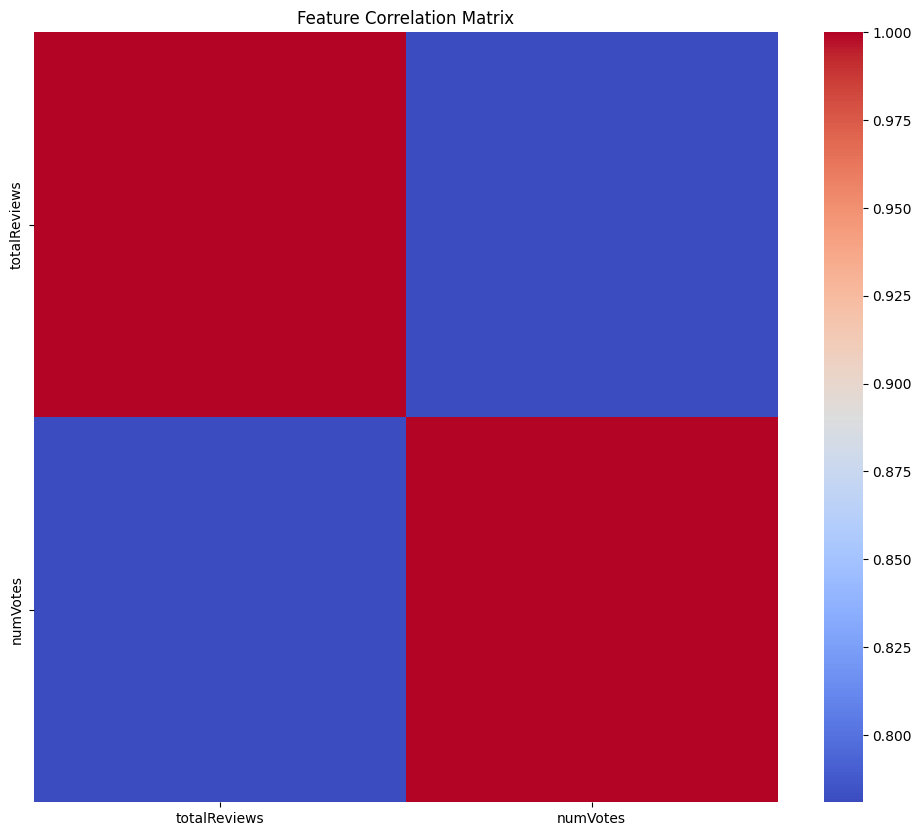

In [90]:
train['totalReviews'] = train['criticReviewsTotal'] + train['userReviewsTotal']

correlation_matrix = train[['totalReviews', 'numVotes']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [122]:
feats = [
    'numRegions',
    'totalMedia',
    'totalCredits', 
    'totalNominations',
    # 'rating',
    'startYear',
    # 'canHaveEpisodes',
    'fill_runtimeMinutes_Bruno',
    # 'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
    # 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
    # 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
    # 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
    # 'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
    # 'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
    'countryOfOrigin_freq_enc',
    # 'countryOfOrigin_NA',
    # 'countryOfOrigin_AF',
    'countryOfOrigin_AS',
    'countryOfOrigin_EU',
    # 'countryOfOrigin_OC',
    # 'countryOfOrigin_SA',
    # 'countryOfOrigin_UNK',
    # 'is_from_Oceania', 'is_from_North America',
    # 'is_from_South America', 'is_from_Asia', 'is_from_Africa',
    # 'is_from_Europe',
    # 'criticReviewsTotal', 'userReviewsTotal',
]

In [128]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Prepare the data
X_train = train[feats].copy()
X_test = test[feats].copy()

# Scale the features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

y_train = train['has_lowEngagement'].copy()
y_test = test['has_lowEngagement'].copy()

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': randint(10, 60),
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 30),
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': uniform(0.0, 0.05),  # cost-complexity pruning
    'splitter': ['best', 'random']
}

# Initialize the Isolation Forest model
base_clf = DecisionTreeClassifier(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=base_clf,
    param_distributions=param_grid,
    n_iter=200,
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit Randomized Search to the training data
random_search.fit(X_train, y_train)

# Use the best estimator from random search
clf = random_search.best_estimator_

print(clf)

# Predict anomalies (-1 for anomaly, 1 for normal)
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

# Generate classification report
report_train = classification_report(train['has_lowEngagement'], train_pred)
report_test = classification_report(test['has_lowEngagement'], test_pred)

print("Classification Report for Train Data:")
print(report_train)
print("\nClassification Report for Test Data:")
print(report_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


DecisionTreeClassifier(ccp_alpha=0.0007039911357542228, criterion='log_loss',
                       max_depth=26, min_samples_leaf=3, random_state=42)
Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.80      0.63      0.71      5067
           1       0.85      0.93      0.89     11105

    accuracy                           0.83     16172
   macro avg       0.82      0.78      0.80     16172
weighted avg       0.83      0.83      0.83     16172


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67      1698
           1       0.83      0.91      0.87      3686

    accuracy                           0.81      5384
   macro avg       0.79      0.75      0.77      5384
weighted avg       0.81      0.81      0.81      5384



In [130]:
clf.feature_importances_

array([0.41736669, 0.1845851 , 0.23425124, 0.00676695, 0.05303829,
       0.03781383, 0.05729781, 0.00702336, 0.00185674])